In [1]:
%%javascript
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "theNotebook = " + "'"+attribs['data-notebook-name'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
try:
    run_once
except NameError:
    run_once = False
if not run_once:
    run_once = True
    
    import time
    import logging
    reload(logging)
    FORMAT = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    logpath = 'community-generation-delta.log'
    logging.basicConfig(filename=logpath,level=logging.DEBUG, format=FORMAT)
    print("logging to %s" % (logpath))
    logger = logging.getLogger()
    #logger.basicConfig(filename='/notebooks/Export Microbiome to database.log',level=logging.DEBUG)
    logger.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)

    # create formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    # add formatter to ch
    ch.setFormatter(formatter)

    # add ch to logger
    logger.addHandler(ch)

logging to community-generation.log


In [ ]:
%%bash

pip2 install python-louvain

In [4]:
%matplotlib inline
import pandas, pandas.io
import re
import seaborn as sns
import math
import scipy, scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import string
import networkx as nx
import community
logging.getLogger('boto').setLevel(logging.INFO)
logging.getLogger('p100').setLevel(logging.INFO)

In [5]:
def select(res, substring=None, ids = None):
    """Helper function to search network dataframe.
    """
    if substring:
        ss_sel = _select_substring(res,  substring.lower() )
    if ids:
        raise Exception("id unimplemented")
        id_sel = _select_ids(res, ids[0], ids[1])
    return res[ss_sel]

def _select_ids( res, datasource_id, variable_id ):
    sel = (res.ds_id_1 == datasource_id & res.variable_id_1 == variable_id )
    sel = sel | (res.ds_id_2 == datasource_id & res.variable_id_2 == variable_id )
    return sel
def _select_substring( res, substring ):
    
    ann = res.annotations_1.unique().tolist() + res.annotations_2.unique().tolist()
    sel = res.annotations_1 == ''
    text =  set([a for a in ann if a.lower().find(substring) >= 0.0])
    for an in text:
        sel = sel | (res.annotations_1 == an)
        sel = sel | (res.annotations_2 == an) 
    return sel

In [6]:
DATA_DIR = '/home/jovyan/work/data'

In [7]:
res = pandas.read_pickle(DATA_DIR + '/community/full.DELTA.correlation.network.pkl')

In [8]:
max_pval_adj = 0.05

sig = res[(res.pval_adj < max_pval_adj)]
sig.shape

(32205, 12)

In [9]:
sub = select(sig, 'COACH')
remove = sub.index
mask1 = sig.index.isin(remove)
print mask1.sum()
sub = select(sig, 'AGES')
remove = sub.index
mask2 = sig.index.isin(remove)
print mask2.sum()
sub = select(sig, 'CHEMS.None.Genova.height')
remove = sub.index
mask3 = sig.index.isin(remove)
print mask3.sum()
sig = sig[~(mask1 | mask2 | mask3)]
sig.shape

853
71
4


(31277, 12)

In [10]:
rem = pandas.read_csv(DATA_DIR + '/community/duplicate_measurements.05012016.txt', sep='\t', header=None)
rem.columns = ['ann1', 'ann2']

mask = []
for index, row in sig.iterrows():
    
    found = False
    for index2, row2 in rem.iterrows():
        
        if (row['annotations_1']==row2['ann1']) and (row['annotations_2']==row2['ann2']):
            found = True
            break;
        elif (row['annotations_1']==row2['ann2']) and (row['annotations_2']==row2['ann1']):
            found = True
            break;

    mask.append(found)
    
mask = np.array(mask)
sig = sig[~mask]
sig.shape

(31222, 12)

In [11]:
# Save resulting network to text file
sig.to_pickle(DATA_DIR + '/community/correlation_network.DELTA.sig.nodups.FULL.pkl')

In [12]:
mask = []
# Now remove all correlations between pairwise elements
for index, row in sig.iterrows():
    
    cat1 = row['annotations_1'][0:5]
    cat2 = row['annotations_2'][0:5]
    
    if (cat1 == cat2):
        mask.append(False)
    else:
        mask.append(True)
        
sig = sig[mask]
print sig.shape

(2406, 12)


In [13]:
print select(sig, 'GENOM').shape
print select(sig, 'MICRO').shape
print select(sig, 'PROTE').shape
print select(sig, 'METAB').shape
print select(sig, 'CHEMS').shape

(0, 12)
(21, 12)
(829, 12)
(2109, 12)
(1860, 12)


In [14]:
# Save resulting network to text file
sig.to_pickle(DATA_DIR + '/community/correlation_network.DELTA.sig.nodups.INTRAOMIC.pkl')

In [15]:
# Load data into networkx
g = nx.Graph()

In [16]:
# add a set of nodes
nodes = sig['annotations_1'].append(sig['annotations_2']).unique()
datatype = {}
super_pathways = {}
sub_pathways = {}

# Loop over nodes and get type
for e in nodes:
    tokens = e.split('.')

    datatype[e] = tokens[0]
    if (datatype[e]=='METAB'):
        super_pathways[e] = tokens[2]
        sub_pathways[e] = tokens[3]
    
g.add_nodes_from(list(nodes))
nx.set_node_attributes(g, 'type', datatype)
nx.set_node_attributes(g, 'super_pathway', super_pathways)
nx.set_node_attributes(g, 'sub_pathway', sub_pathways)

In [17]:
# Add a set of edges
edges = []
attributes = []
for row in sig.iterrows():
    g.add_edge(row[1]['annotations_1'], row[1]['annotations_2'], {'weight':abs(row[1]['coefficient']), 'non_abs_weight':row[1]['coefficient']})  

In [18]:
# Count number of nodes and edges
print g.number_of_nodes(), g.number_of_edges()

822 2406


In [19]:
import sys
def girvan_newman(G, k=None, weight=None):
    """Find communities in graph using Girvan–Newman method.

    Parameters
    ----------
    G : NetworkX graph

    weight : string, optional (default=None)
       Edge data key corresponding to the edge weight.

    Returns
    -------
    List of tuples which contains the clusters of nodes.

    Examples
    --------
    >>> G = nx.path_graph(10)
    >>> comp = girvan_newman(G)
    >>> comp[0]
    ([0, 1, 2, 3, 4], [8, 9, 5, 6, 7])

    Notes
    -----
    The Girvan–Newman algorithm detects communities by progressively removing
    edges from the original graph. Algorithm removes edge with the highest
    betweenness centrality at each step. As the graph breaks down into pieces,
    the tightly knit community structure is exposed and result can be depicted
    as a dendrogram.
    """
    # The copy of G here must include the edge weight data.
    g = G.copy().to_undirected()
    components = []
    while g.number_of_edges() > 0:
        print "Number of edges", g.number_of_edges()
        sys.stdout.flush()
        _remove_max_edge(g, k, weight)
        components.append(tuple(list(H)
                                for H in nx.connected_component_subgraphs(g)))
    return components

def _remove_max_edge(G, k=None, weight=None):
    """
    Removes edge with the highest value on betweenness centrality.

    Repeat this step until more connected components than the connected
    components of the original graph are detected.

    It is part of Girvan–Newman algorithm.

    :param G: NetworkX graph
    :param weight: string, optional (default=None) Edge data key corresponding
    to the edge weight.
    """
    number_components = nx.number_connected_components(G)
    #print number_components
    while nx.number_connected_components(G) <= number_components:
        betweenness = nx.edge_betweenness_centrality(G, k=k, weight=weight)
        #print "finished betweenness", nx.number_connected_components(G), number_components
        max_value = max(betweenness.values())
        #print "max_value", max_value
        # Use a list of edges because G is changed in the loop
        for edge in list(G.edges()):
            if betweenness[edge] == max_value:
                G.remove_edge(*edge)

In [20]:
# Note: this takes about an hou
communities = girvan_newman(g, weight='weight')

# Save the community to a file
cindex = 0
gindex = 0

with open(DATA_DIR + '/community/generated.communities.DELTA.sig.nodups.INTRAOMIC.txt', 'w') as f:

    cindex = 0
    for community in communities:
        gindex = 0
        for graph in community:

            for node in graph:
                f.write("%d\t%d\t%s\n"%(cindex, gindex, node))

            gindex += 1

        cindex += 1



Number of edges 2406
Number of edges 2384
Number of edges 2377
Number of edges 2359
Number of edges 2307
Number of edges 2300
Number of edges 2263
Number of edges 2253
Number of edges 2239
Number of edges 2209
Number of edges 2117
Number of edges 2099
Number of edges 2055
Number of edges 2054
Number of edges 2051
Number of edges 2049
Number of edges 1950
Number of edges 1932
Number of edges 1921
Number of edges 1918
Number of edges 1907
Number of edges 1903
Number of edges 1886
Number of edges 1843
Number of edges 1831
Number of edges 1810
Number of edges 1803
Number of edges 1794
Number of edges 1792
Number of edges 1789
Number of edges 1780
Number of edges 1765
Number of edges 1758
Number of edges 1745
Number of edges 1727
Number of edges 1715
Number of edges 1713
Number of edges 1700
Number of edges 1696
Number of edges 1687
Number of edges 1631
Number of edges 1613
Number of edges 1608
Number of edges 1604
Number of edges 1587
Number of edges 1553
Number of edges 1549
Number of edg

In [21]:
len(communities)

213

In [22]:
# Load the community
communities_dict = []

current_community = None
current_subgraph = None
data = {}

# Load the community as a set of dictionaries
with open(DATA_DIR + '/community/generated.communities.DELTA.sig.nodups.INTRAOMIC.txt', 'r') as f:

    for line in f:
        
        tokens = line.strip().split('\t')
        c = int(tokens[0])
        subgraph = int(tokens[1])
        node = tokens[2]

        if (current_community is None):
            current_community = c
            current_subgraph = subgraph
            data[node] = subgraph
            
        elif (c != current_community):          
            communities_dict.append(data)
            data = {}
            current_community = c
            current_subgraph = subgraph
            
        data[node] = subgraph
        
    #if (len(data)>0):
    #    subgraphs.append(data)
        
    #if (len(subgraphs)>0):
    #    communities_dict.append(subgraphs)
            

In [23]:
import community
results = []
count = 0
mods = []
for c in communities_dict:
    mod = community.modularity(c, g)
    results.append((count, mod))
    mods.append(mod)
    count += 1
    
df = pandas.DataFrame(results, columns=['index', 'modularity']).sort_values('modularity', ascending=False)


In [24]:
df.head()

,index,modularity
20,20,0.636553
18,18,0.636361
19,19,0.636220
17,17,0.636173
16,16,0.635888


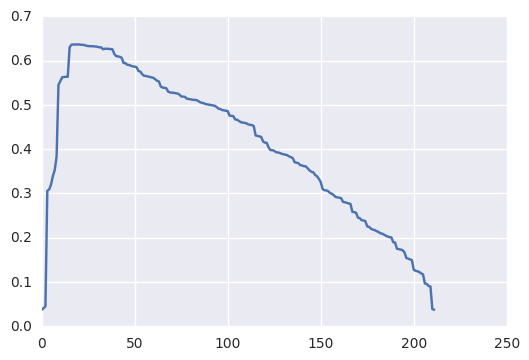

In [25]:
plt.plot(mods)

In [26]:
# Load the community as a list of lists
communities = []

current_community = None
current_subgraph = None
data = []
subgraphs = []

# Load the community as a set of dictionaries
with open(DATA_DIR + '/community/generated.communities.DELTA.sig.nodups.INTRAOMIC.txt', 'r') as f:

    for line in f:
        
        tokens = line.strip().split('\t')
        c = int(tokens[0])
        subgraph = int(tokens[1])
        node = tokens[2]

        if (current_community is None):
            current_community = c
            current_subgraph = subgraph
            
        else:
            
            if (subgraph != current_subgraph):
                subgraphs.append(data)
                data = []
                current_subgraph = subgraph
            
            if (c != current_community):          
                communities.append(subgraphs)
                subgraphs = []
                current_community = c
            
        data.append(node)
        
    if (len(data)>0):
        subgraphs.append(data)
        
    if (len(subgraphs)>0):
        communities.append(subgraphs)
            

In [27]:
COMMUNITY_LEVEL = 20
nnodes = []
nedges = []
for e in communities[COMMUNITY_LEVEL]:
    if (len(e)>1):   
        sg = g.subgraph(e)
        nnodes.append(sg.number_of_nodes())
        nedges.append(sg.number_of_edges())
        
print "Number of communities", len(nnodes), len(nedges)
print sorted(nnodes)
print "Node stats", np.mean(nnodes), np.max(nnodes), np.min(nnodes), np.sum(nnodes)
print "Edge stats", np.mean(nedges), np.max(nedges), np.min(nedges), np.sum(nedges)

# Get percentage of nodes used
print "Percent of nodes in a community", float(np.sum(nnodes)) / g.number_of_nodes()
print "Percent of edges in a community", float(np.sum(nedges)) / g.number_of_edges()

Number of communities 33 33
[2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 10, 13, 15, 16, 19, 23, 23, 29, 29, 31, 92, 118, 131, 209]
Node stats 24.9090909091 209 2 822
Edge stats 59.1515151515 683 1 1952
Percent of nodes in a community 1.0
Percent of edges in a community 0.811305070657


In [28]:
communities = pandas.read_csv(DATA_DIR + '/community/generated.communities.DELTA.sig.nodups.INTRAOMIC.txt', header=None, sep='\t')
communities.columns = ['cindex', 'gindex', 'node']
communities.head()

,cindex,gindex,node
0,0,0,CHEMS.None.Genova.beta_alanine_plasma
1,0,0,PROTE.None.Inflammation.TWEAK.None
2,0,0,PROTE.None.Inflammation.Flt3L.None
3,0,0,PROTE.None.Inflammation.uPA.None
4,0,0,PROTE.None.Inflammation.IL_10RB.None
